In [1]:
%pylab inline
import numpy as np
import scipy as sc
import scipy.ndimage as ndi
import pylab as pl
import matplotlib as mpl
from IPython import display
from itertools import islice
import imp
import warnings
rc("image", cmap="gray")

Populating the interactive namespace from numpy and matplotlib


# File Reader (Legacy Data)

Training data is often stored in the file system. The `dlinputs` library provides a number of convenient iterators over such data in the `sources` subpackage:

- `sources.dirtree` - iterates over samples stored in a directory tree
- `sources.basenames` - the dataset is a file containing basenames, plus a list of extensions
- `sources.tabular` - the dataset is a file containing rows with filenames / data

The `sources.basenames` layout the unpacked file system representation of sharded tar files.

By default, these readers use file name conventions for decoding common data types based on extensions:

- `.png`, `.jpg`, `.jpeg`: image decoding
- `.json`: json decoding
- `.pyd`, `.pickle`: Python pickle decoding
- `.mp`: MessagePack decoding
- `.cls`, `.cls2`, `.index`, `.inx`: integer decoding

Other fields/extensions are returned as strings and you need to decode those yourself.

## Directory Trees

got 6 samples
__epoch__ 0
__path__ 'testdata/dirdata/10'
cls 304
png float32 (793, 600, 3)


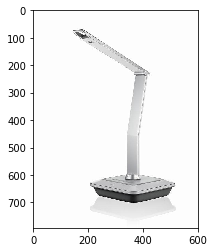

In [2]:
from dlinputs import sources
from dlinputs import utils
data = sources.dirtree("testdata/dirdata", "png,cls", size=6) 
for sample in data:
    utils.print_sample(sample)
    break
imshow(sample["png"])

## Basename Lists

In [3]:
!sed 5q testdata/dirdata.list

dirdata/10
dirdata/12
dirdata/13
dirdata/15
dirdata/18


got 6 samples
['__path__', '__epoch__', 'png', 'cls']
/home/tmb/exp/dlinputs/testdata/dirdata/18


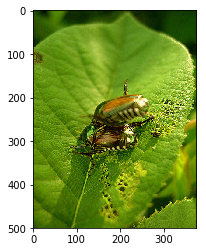

In [4]:
data = sources.basenames("testdata/dirdata.list", "png,cls", size=6)
sample = next(data)
print(list(sample.keys()))
print(sample["__path__"])
imshow(sample["png"])

## Making Basename Lists

In [5]:
!find testdata/dirdata -name '*.png' > basenames
!sed 3q basenames

testdata/dirdata/19.png
testdata/dirdata/12.png
testdata/dirdata/13.png


got 6 samples
['__path__', '__epoch__', 'png', 'cls']
/home/tmb/exp/dlinputs/testdata/dirdata/18


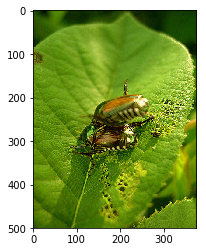

In [6]:
data = sources.basenames("basenames", "png,cls", size=6) 
sample = next(data)
print(list(sample.keys()))
print(sample["__path__"])
imshow(sample["png"])

## Tabular Dataset Descriptions

In [7]:
!sed 5q testdata/dirdata.tsv

dirdata/10.png	dirdata/10.cls
dirdata/12.png	dirdata/12.cls
dirdata/13.png	dirdata/13.cls
dirdata/15.png	dirdata/15.cls
dirdata/18.png	dirdata/18.cls


got 6 samples
['__epoch__', 'png', '__path__png', 'cls', '__path__cls']
/home/tmb/exp/dlinputs/testdata/dirdata/15.png


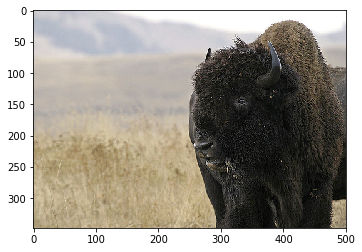

In [8]:
from dlinputs import sources
from dlinputs import utils
data = sources.tabular("testdata/dirdata.tsv", "png,cls", size=6)
sample = next(data)
print(list(sample.keys()))
print(sample["__path__png"])
imshow(sample["png"])

## Inline Data in Tabular Datasets

In [9]:
!sed 5q testdata/dirdata.tsv2

dirdata/10.png	304
dirdata/12.png	551
dirdata/13.png	180
dirdata/15.png	165
dirdata/18.png	625


got 6 samples
['__epoch__', 'png', '__path__png', '_cls']
/home/tmb/exp/dlinputs/testdata/dirdata/15.png


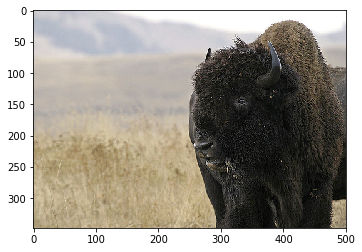

In [10]:
data = sources.tabular("testdata/dirdata.tsv2", "png,_cls", size=6)
sample = next(data)
print(list(sample.keys()))
print(sample["__path__png"])
imshow(sample["png"])

## Search Paths

In [11]:
from dlinputs import paths
path = "/work/DATABASES:./testdata"
paths.find_file(path, "sample.db", verbose=True)

trying ./testdata/sample.db


'./testdata/sample.db'

In [12]:
path = "/work:./testdata"
paths.find_directory(path, "dirdata", "10.png", verbose=True)

trying ./testdata/dirdata
testing ./testdata/dirdata/10.png


'./testdata/dirdata'

# Database Reader

Sqlite databases are convenient for local datasets. They can be up to several terabytes large. `sqlitedb.sqlitedb` returns dictionaries containing each column as a field. Since there are no conventions for mapping column names to types, decoding needs to be explicit using `filters.map`.

In [13]:
!sqlite3 testdata/sample.db .schema

CREATE TABLE train (image blob, cls integer, inx integer);


[b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x00\x00\x00\xd3IDATx\x9c\xd5\xd0\xa1\x17\xc1`\x14\x05\xf0W(+\xca\x92\xb2\xa2,\xcb\x04\x8a2U\x12&\t\x04\x85\xbf\x80\xb0\xaeLQ\xad\xc8\x84\xad(\xaa\xb3\xa0P\xbe@!l\x81\xf0\xee\xa7\x7f\xf3\x9a\xe2\xd6\xdf\xb9\xe7\xbds\x89~\x99\xf2:\xad\x888cx\x9255\xf6\x929g\x9cl\xc1\xec\x84UC0k\x0bnJ\xbd\x14z \xf5B\xf0\xa0$\xd8,\x7fO\xa4GC\xf0\\\xb2\x08: \xaa\x8dj\xe5\xa2\r\xc1\xd3\x92\xb3\xcd9\xeb\x15\xac\x9d\xeb\xa0\xea\xa5P\nK\xd3\xec\x0b\xc7\x95q\x86\xb8~@\xcb\xc4\x15\xae\xeeBceEP\x96a\xee\x83\xfd\xce+\xf3\x9d\x10\xb7\x8eY\xecB\xd9\t\xa2Q\x8ag\xc1(\xe0\x9d\x0b\xbe3N_\x96u\x1f\x80\x86>.\xcc{DD\xd4\xdf0bO\xd8\xf5/\xf2\x01Qhd\r\x98^\xb6R\x00\x00\x00\x00IEND\xaeB`\x82', 6, 999]
6


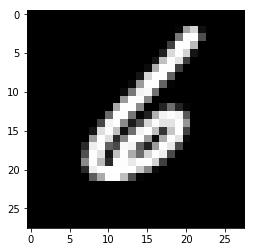

In [14]:
warnings.filterwarnings("error")
from dlinputs import sqlitedb, filters, utils
data = sqlitedb.sqlitedb("testdata/sample.db")
data = filters.map(image=utils.pilgray, cls=int)(data)
for sample in data:
    imshow(sample["image"])
    print(sample["cls"])
    break